In [801]:
import numpy as np
import pandas as pd
import scipy
from scipy import integrate
import math
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline  


Начальные данные

In [802]:
# радиус барабана
Rb = 10

# радиус объекта
Ro = 1

# высота объекта
Ho = 10

# угловая скорость барабана
Wb = 0.175                    # рад/с ~10 град в сек

# угловая скорость объекта
Wo = 0.175                  # рад/с ~10 град в сек

# расстояние до мишени
L = 20

# ширина мишени
Wm = 8

# высота мишени
Hm = 15

# количество объектов
obj_num = 8

In [803]:
starting_point_b = np.array([0, Rb])
starting_point_o = np.array([0, Ro])

In [804]:
# angle in radians
def rotate_point_0 (point, angle):
    x1 = point[0] * np.cos(angle) - point[1] * np.sin(angle)
    y1 = point[0] * np.sin(angle) + point[1] * np.cos(angle)
    return np.array([x1, y1])

In [805]:
point = np.array([1, 2])

In [806]:
angle = 90
angle_rad = np.deg2rad(angle)
angle_rad


1.5707963267948966

In [807]:
rotate_point_0 (point, angle_rad)

array([-2.,  1.])

In [808]:
# угол поворота, w - угловая скорость
def get_current_angle (w, t):
    return (w*t) % (2*np.pi)

In [809]:
def get_object_center (Wb, point_b, t):
    alpha_b = get_current_angle(Wb, t)
    vec_b = rotate_point_0(point_b, alpha_b)
    return vec_b

In [810]:
# point_b  начальное опложение центра объекта, point_o - начальное положение точки на объекте относительно его центра
def get_point_coords (Wb, Wo, point_b, point_o, t):
    vec_b = get_object_center(Wb, point_b, t)
    alpha_o = get_current_angle(Wo, t)
    vec_o = rotate_point_0(point_o, alpha_o)
    return vec_b + vec_o

In [811]:
def get_normal_vec(center, point):
    return point - center

In [812]:
time_spent = 1

In [813]:
cent = get_object_center(Wb, starting_point_b, time_spent)
cent

array([-1.74108138,  9.84726539])

In [814]:
point = get_point_coords(Wb, Wo, starting_point_b, starting_point_o, time_spent)
point

array([-1.91518951, 10.83199193])

In [815]:
normal = get_normal_vec(cent, point)
normal

array([-0.17410814,  0.98472654])

In [816]:
def get_cosin(v1, v2):
    return 1 - scipy.spatial.distance.cosine(v1, v2)

In [817]:
def get_sin(v1, v2):
    return math.sqrt(1 - get_cosin(v1, v2)**2)

In [818]:
get_cosin([1, 0], [0.25, -1])

0.24253562503633297

In [819]:
get_sin([1, 0], [0.25, -1])

0.9701425001453319

In [820]:
# f= lambda y, x: x*y**2 + 1
# integrate.dblquad(f, 6, 9, lambda x: -1, lambda x: x+1)

In [821]:
# расстояние между скрещивающимися прямыми
def closestDistanceBetweenLines(a0,a1,b0,b1,clampAll=False,clampA0=False,clampA1=False,clampB0=False,clampB1=False):

    ''' Given two lines defined by numpy.array pairs (a0,a1,b0,b1)
        Return the closest points on each segment and their distance
    '''

    # If clampAll=True, set all clamps to True
    if clampAll:
        clampA0=True
        clampA1=True
        clampB0=True
        clampB1=True


    # Calculate denomitator
    A = a1 - a0
    B = b1 - b0
    magA = np.linalg.norm(A)
    magB = np.linalg.norm(B)

    _A = A / magA
    _B = B / magB

    cross = np.cross(_A, _B);
    denom = np.linalg.norm(cross)**2


    # If lines are parallel (denom=0) test if lines overlap.
    # If they don't overlap then there is a closest point solution.
    # If they do overlap, there are infinite closest positions, but there is a closest distance
    if not denom:
        d0 = np.dot(_A,(b0-a0))

        # Overlap only possible with clamping
        if clampA0 or clampA1 or clampB0 or clampB1:
            d1 = np.dot(_A,(b1-a0))

            # Is segment B before A?
            if d0 <= 0 >= d1:
                if clampA0 and clampB1:
                    if np.absolute(d0) < np.absolute(d1):
                        return a0,b0,np.linalg.norm(a0-b0)
                    return a0,b1,np.linalg.norm(a0-b1)


            # Is segment B after A?
            elif d0 >= magA <= d1:
                if clampA1 and clampB0:
                    if np.absolute(d0) < np.absolute(d1):
                        return a1,b0,np.linalg.norm(a1-b0)
                    return a1,b1,np.linalg.norm(a1-b1)


        # Segments overlap, return distance between parallel segments
        return None,None,np.linalg.norm(((d0*_A)+a0)-b0)



    # Lines criss-cross: Calculate the projected closest points
    t = (b0 - a0);
    detA = np.linalg.det([t, _B, cross])
    detB = np.linalg.det([t, _A, cross])

    t0 = detA/denom;
    t1 = detB/denom;

    pA = a0 + (_A * t0) # Projected closest point on segment A
    pB = b0 + (_B * t1) # Projected closest point on segment B


#     # Clamp projections
#     if clampA0 or clampA1 or clampB0 or clampB1:
#         if clampA0 and t0 < 0:
#             pA = a0
#         elif clampA1 and t0 > magA:
#             pA = a1

#         if clampB0 and t1 < 0:
#             pB = b0
#         elif clampB1 and t1 > magB:
#             pB = b1

#         # Clamp projection A
#         if (clampA0 and t0 < 0) or (clampA1 and t0 > magA):
#             dot = np.dot(_B,(pA-b0))
#             if clampB0 and dot < 0:
#                 dot = 0
#             elif clampB1 and dot > magB:
#                 dot = magB
#             pB = b0 + (_B * dot)

#         # Clamp projection B
#         if (clampB0 and t1 < 0) or (clampB1 and t1 > magB):
#             dot = np.dot(_A,(pB-a0))
#             if clampA0 and dot < 0:
#                 dot = 0
#             elif clampA1 and dot > magA:
#                 dot = magA
#             pA = a0 + (_A * dot)


    return pA,pB,np.linalg.norm(pA-pB)

In [822]:
def is_hidden_by_another_object(a0, a1, objects_centers, Ro):
    for center in objects_centers:
        b0 = np.array([center[0], center[1], 0])
        b1 = np.array([center[0], center[1], 1])
        pA, pB, l = closestDistanceBetweenLines(a0, a1, b0, b1)
        if l <= Ro:
            return True
    return False

In [823]:
def get_function_value (target_p, object_p, n, objects_centers, Ro):

    
    n1 = np.array([0, 0, -1])   # нормаль к плоскости мишени
    s = target_p - object_p     # вектор он точки на объекте к точке на мишени
    s1 = object_p - target_p 
    cos_teta = get_cosin(n, s)
    
#     print ("target=", target_p)
#     print ("object=", object_p)
#     print ("normal=", n)
#     print ("s=", s)
#     print ("\n")
    
    
#     if (cos_teta > 0):
#         print ("reachable")
    if cos_teta < 0:            # точка на объекте не видима с точки на мишени
        return 0
    
    if is_hidden_by_another_object(object_p, target_p, objects_centers, Ro):     # точка скрыта за других цилиндром
        return 0;
    
    cos_teta1 = abs(get_cosin(n1, s1))
    sin_teta1 = abs(get_sin(n1, s1))
    
    res = (sin_teta1 * cos_teta)
    if (res < 0):
        print ("Achtung! res = ", res)
    return res # * Im0

# point - точка на цилиндре, n - нормаль к этой точке
# t1 - верхняя левая точна мишени t2 - нижняя правая точка мишени (мишень - плоская)
# objects_centers - центры цилиндров КРОМЕ рассматриваемого
def integrate_one_point(point, n, t1, t2, objects_centers, Ro):
    x_target = t1[0]
    f= lambda y, z: get_function_value (np.array([x_target, y, z]), point, n, objects_centers, Ro)
    (val, err) = integrate.dblquad(f, t1[1], t2[1], lambda z: t1[2], lambda z: t2[2], epsabs = 1, epsrel=1)
#     print (val, err)
    return val

In [824]:
#integrate_one_point (np.array([50, -25, 0]), np.array([0, -1, 0]), np.array([150, 10, 20]), np.array([150, -10, -20]))

In [825]:
def get_target_coords (L, Wm, Hm):
    t1 = np.array([L, Wm/2, Hm/2])
    t2 = np.array([L, -Wm/2, -Hm/2])
    return (t1, t2)
    

In [826]:
# point_o - начальное положение точки на объекте относительно его центра
def get_point_coords (point_center, Wo, start_angle, t, Ro):
    alpha_o = (get_current_angle(Wo, t) + start_angle) % (2*np.pi)
    point_o = np.array([0, Ro])
    vec_o = rotate_point_0(point_o, alpha_o)
    return point_center + vec_o

In [827]:
def get_object_points(point_center, num, Wo, t, Ro):
    res = []
    delta = (2*np.pi) / (num)
    for i in range (0, num):
        p = get_point_coords (point_center, Wo, delta*i, t, Ro)
        res.append([p[0], p[1], 0])
    return res

In [828]:
#get_object_points([0, 0], 12, 0.175, 0, Ro)

In [829]:
turn_time = 6.283/ abs(Wb) # время полного оборота барабана

In [830]:
turn_time

35.902857142857144

In [831]:
time_n = 10    # количество измерений за 1 оборот

In [832]:
time_delta = turn_time / time_n
time_delta

3.5902857142857143

In [833]:
turns_num = 10    # количество оборотов барабана

In [834]:
calc_num = time_n * turns_num
calc_num

100

In [835]:
# возвращает центры цилиндров, кроме первого (рассматриваемого)
def get_objects_centers(Wb, starting_point_b, cur_time, obj_num):
    delta = np.pi * 2 / obj_num;
    
    res = []
    
    for i in range (1, obj_num):
        alpha_b = (get_current_angle(Wb, cur_time) + delta * i) % (2*np.pi)
        vec_b = rotate_point_0(starting_point_b, alpha_b)
        res.append(vec_b)
    return np.array(res)

In [836]:
#get_objects_centers(Wb, starting_point_b, 4, 8)

In [837]:
cur_time = 0
obj_point_num = 12      # колчество точек на цилиндре, в которых вычисляется толщина

res = np.zeros(obj_point_num)
t1, t2 = get_target_coords (L, Wm, Hm)

for i in tqdm.notebook.tqdm(range (0, calc_num)):
#     print ("\nturn\n")
    cent = get_object_center(Wb, starting_point_b, cur_time)
    cent_3d = np.array([cent[0], cent[1], 0])
    pts = get_object_points(cent, obj_point_num, Wo, cur_time, Ro)
    
    centers = get_objects_centers(Wb, starting_point_b, cur_time, obj_num)
    
    for i in range (0, obj_point_num):
        p = pts[i]
        normal = get_normal_vec(cent_3d, p)
        normal_3d = np.array([normal[0], normal[1], 0])
        
        res[i] = res[i] + time_delta * integrate_one_point(pts[i], normal_3d, t1, t2, centers, Ro)
    
    cur_time += time_delta

    
res

array([ 4066.53288855,  5261.54623017,  6908.05900218,  8811.32820461,
       10233.90302749, 10925.16127237, 11535.97761531, 10954.01922458,
       10350.06581041,  8797.64694668,  6833.02892754,  5291.61021423])

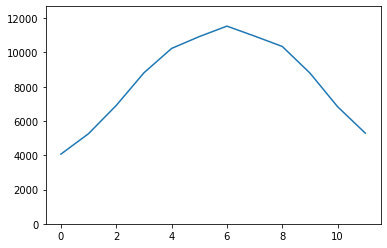

In [838]:
plt.figure()
plt.plot(res)
plt.ylim(bottom = 0, top = res.max()*1.1)
plt.show()

In [839]:
res.max()/res.min()

2.836809127449014